# EEL7065 - Projeto de filtro para detecção de tons DTMF

Trabalho da disciplina de Sinais e Sistemas Discretos (EEL7065), depto. Eng. Elétrica da Universidade Federal de Santa Catarina (UFSC). Prof. Joceli Mayer

Obs.: Comentários no código em inglês para possibilitar reuso e publicação eventualmente.

Projetos de filtros baseado no tutorial: [Designing an FIR filter in Python](http://www.ee.iitm.ac.in/~nitin/teaching/ee5480/firdesign.html)


In [1]:
# Import functions to keep it simple to use
from pylab import * 
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import simpleaudio as sa
from goertzel import goertzel

# charts styling
plt.style.use('ggplot')
#plt.style.use('seaborn-notebook')
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8 # increases figure size
#matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
#rcParams['font.family'] = 'Arial Narrow'

## Sinal de entrada
Exemplo de áudio fornecido.

--- Parâmetros do sinal de entrada ---
Frequência de amostragem (Hz): 44100
Frequência de Nyquist    (Hz): 22050.0
Bits por amostra             : 16
Duração                   (s): 26.97578231292517


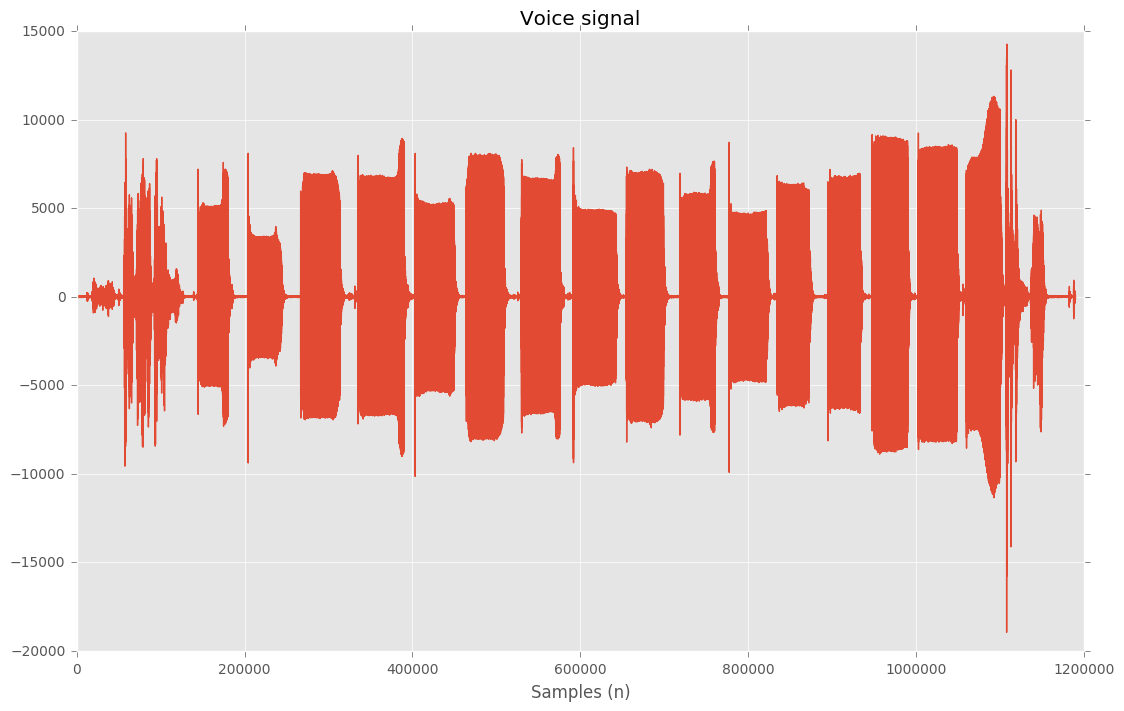

In [2]:
spf = wave.open('testall_mono.wav','r') # Sample file provided

# Extract raw audio from wav file
s = spf.readframes(-1)
s = np.fromstring(s, 'Int16')

# Shortens audio for testing
#s = s[0:int(round(len(s)/2))]

# Extract signal properties
num_channels = spf.getnchannels()
bytes_per_sample = spf.getsampwidth()
sample_rate = spf.getframerate()
num_frames = spf.getnframes()
duration = num_frames / float(sample_rate) # gets duration in seconds

nyq_rate = sample_rate / 2.0

# If stereo, prints error
if num_channels == 2:
    print ('Just mono files accepted.')
    sys.exit(0)

print('--- Parâmetros do sinal de entrada ---')
print('Frequência de amostragem (Hz): ' + str(sample_rate))
print('Frequência de Nyquist    (Hz): ' + str(nyq_rate))
print('Bits por amostra             : ' + str(bytes_per_sample*8))
print('Duração                   (s): ' + str(duration))

#plt.figure(1)
plt.xlabel('Samples (n)')
plt.title('Voice signal')
plt.plot(s)
plt.show()

## Espectro do sinal de voz

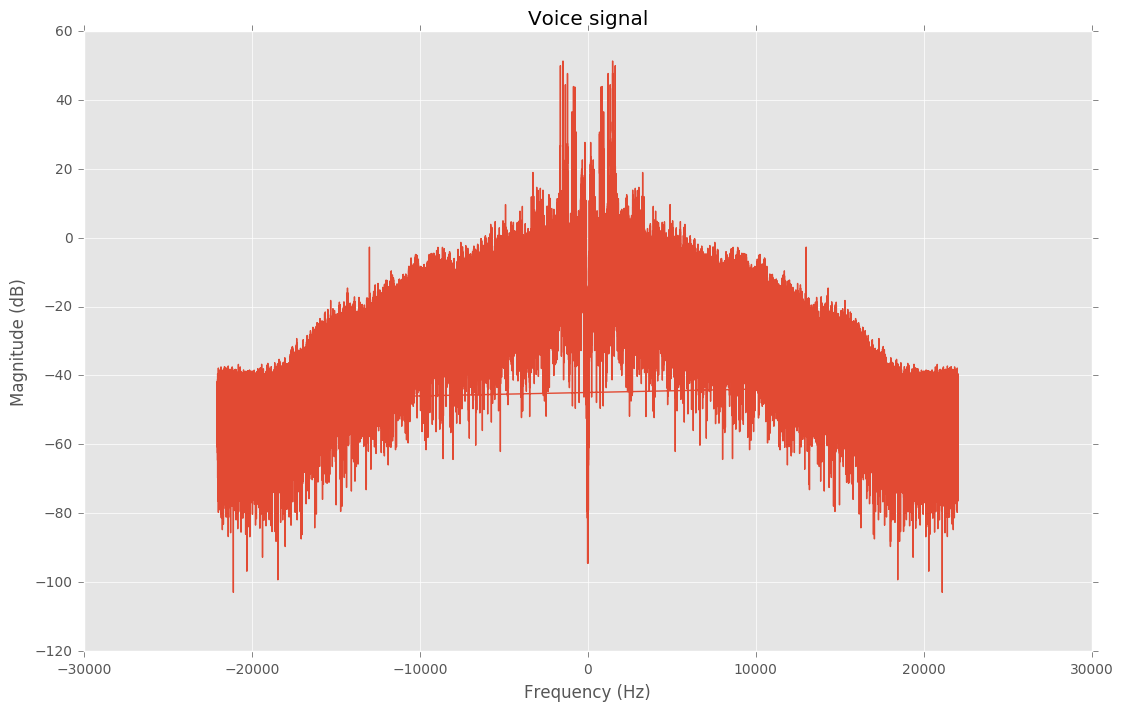

In [3]:
# gets fft frequency to plot properly
n = s.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

#ft_pure = fft(s_pure)/len(s_pure)
ft_s = fft(s)/len(s)

#plt.plot(20*log10(abs(ft_pure)))
plt.plot(freq, 20*log10(abs(ft_s)))
plt.title('Voice signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
#plt.legend(['voice signal wave FFT'], loc='best')
plt.show()

## Projeto do filtro anti-recobrimento

### `firwin`

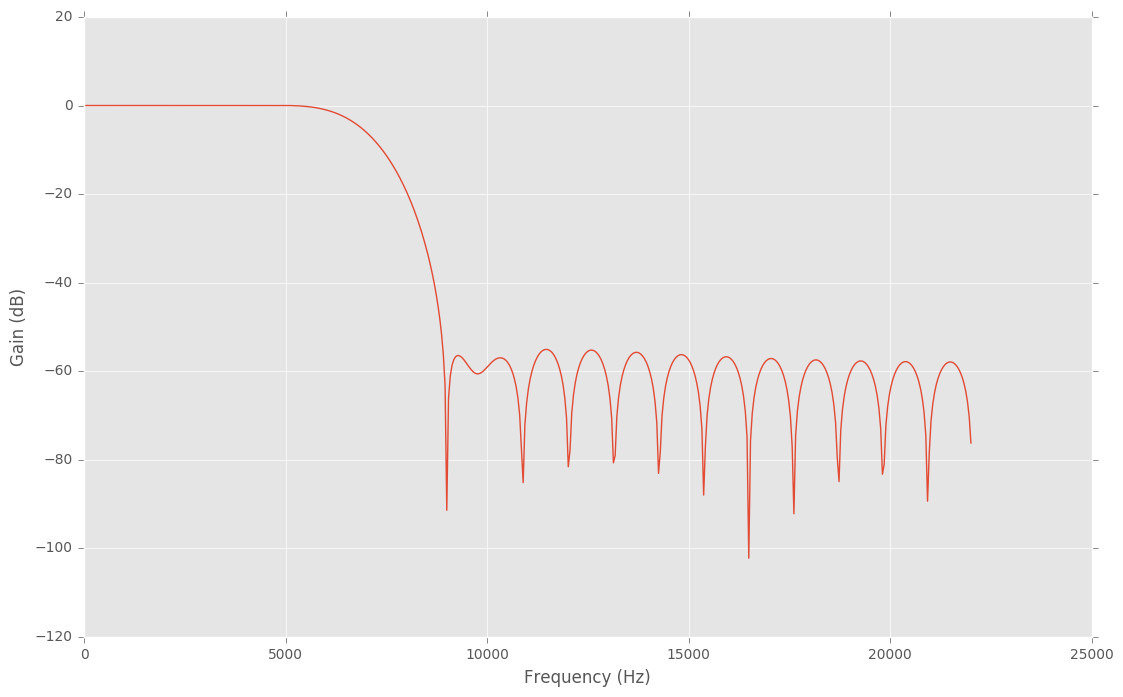

In [4]:
# filter design FIR window algorithm
from scipy.signal import firwin
lpf1 = firwin(numtaps=40, cutoff=7000.0, window='hamming', nyq=nyq_rate) # cutoff is a fraction of Nyquist frequency

from scipy.signal import freqz
w, h = freqz(lpf1)

plt.plot((w/(2*pi))*sample_rate, 20*log10(abs(h)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.show()

## Escolher o filtro (adicionar diferentes opções, janelas, etc)

In [5]:
lpf = lpf1
#lpf = lpf2

## Aplicar o filtro 
Utiliza a função `filtfilt` que resulta em fase linear (sem delay, ou delay uniforme).

In [6]:
# filtering the signal with lfilter
from scipy.signal import filtfilt
s1 = filtfilt(lpf, 1, s)

## Espectro do sinal filtrado

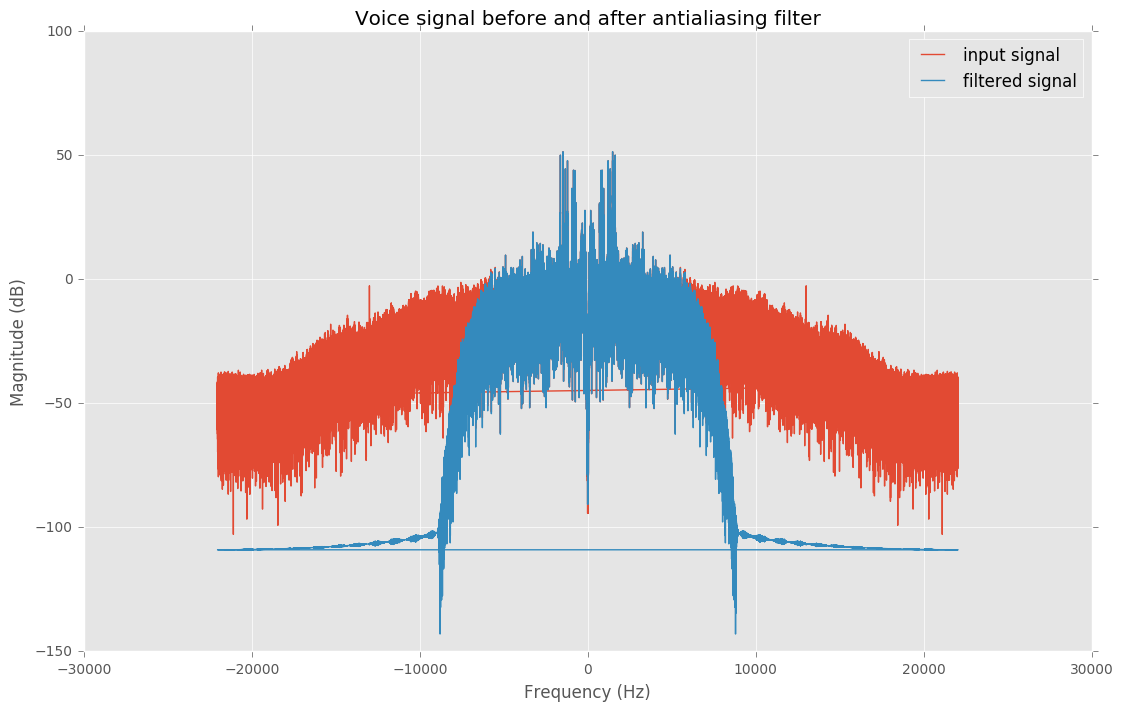

In [7]:
# plotting in frequency

# gets fft frequency to plot properly
n = s.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

ft = fft(s)/len(s)
ft1 = fft(s1)/len(s1)

plt.plot(freq, 20*log10(abs(ft)))
plt.plot(freq, 20*log10(abs(ft1)))
plt.title('Voice signal before and after antialiasing filter')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
legend(('input signal', 'filtered signal'), loc='best')
plt.show()

## Ouvir sinal de entrada filtrado

In [8]:
# makes array c_contiguous in memory
s1 = np.ascontiguousarray(s1, dtype=np.int16)

play_obj = sa.play_buffer(s1, num_channels, bytes_per_sample, sample_rate)
play_obj.wait_done()

## Redução da taxa de amostragem

In [9]:
sample_rate_down = 44100/6             # sampling frequency [Hz]
t_down = np.linspace(0, 1, sample_rate_down, endpoint=False)

nyq_rate_down = sample_rate_down / 2.0

from scipy.signal import decimate
s_down = decimate(s1, 6, 150, 'fir', zero_phase=True)

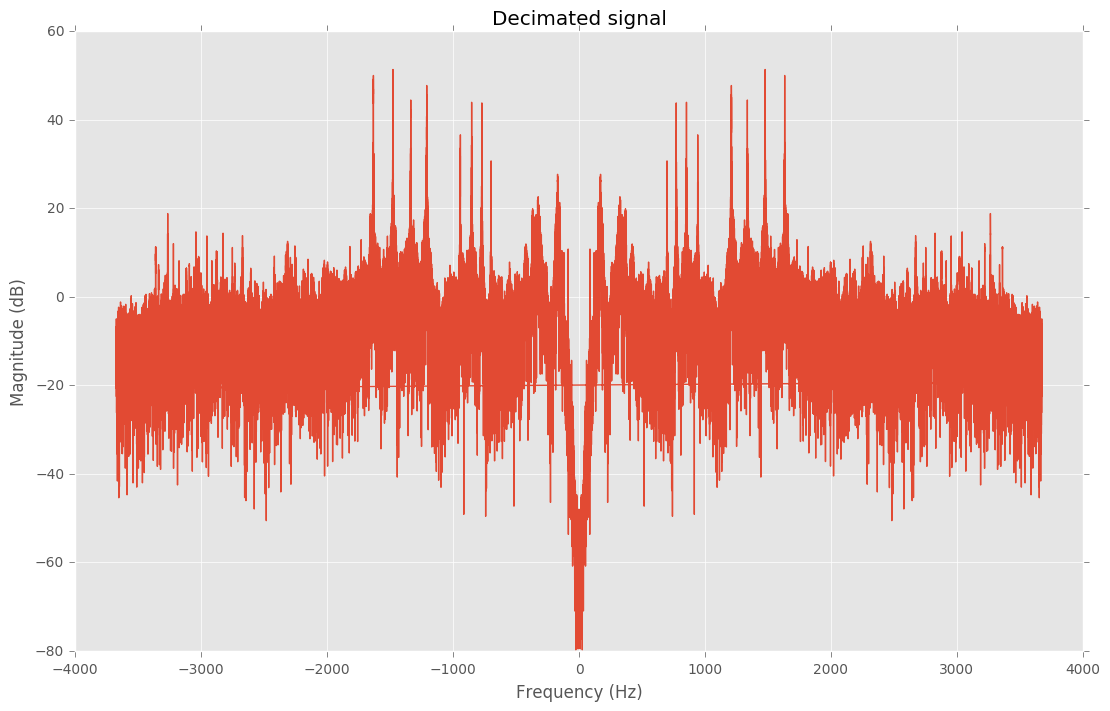

In [10]:
# plotting in frequency

n = s_down.size
timestep = 1.0 / sample_rate_down
freq = np.fft.fftfreq(n, d=timestep)

#ft1 = fft(s1)/len(s1) # obs.: already calculated previously in the code
ft2 = fft(s_down)/len(s_down)

#plt.plot(20*log10(abs(ft1)))
plt.plot(freq, 20*log10(abs(ft2)))
plt.title('Decimated signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.show()

## Ouvir sinal dizimado (somente por curiosidade, não aconteceria na prática) 

In [11]:
# makes array c_contiguous in memory
#f = np.ascontiguousarray(f, dtype=np.int16)

#play_obj = sa.play_buffer(f, num_channels, bytes_per_sample, 8000) # 8 kHz just to test, as it is close to 7.35 kHz and is a standard audio freq
#play_obj.wait_done()

## Função para detecção de tons baseado na potência das frequências predefinidas

In [12]:
def recognize_digit(power_l, power_c):
    threshold = 1e9
    
    digit = '.'
    
    if (power_l[0] > threshold):
        if (power_c[0] > threshold):
            digit = '1'
        elif (power_c[1] > threshold):
            digit = '2'
        elif (power_c[2] > threshold):
            digit = '3'
        elif (power_c[3] > threshold):
            digit = 'A'
    
    elif (power_l[1] > threshold):
        if (power_c[0] > threshold):
            digit = '4'
        elif (power_c[1] > threshold):
            digit = '5'
        elif (power_c[2] > threshold):
            digit = '6'
        elif (power_c[3] > threshold):
            digit = 'B'      
        
    elif (power_l[2] > threshold):
        if (power_c[0] > threshold):
            digit = '7'
        elif (power_c[1] > threshold):
            digit = '8'
        elif (power_c[2] > threshold):
            digit = '9'
        elif (power_c[3] > threshold):
            digit = 'C'
    
    elif (power_l[3] > threshold):
        if (power_c[0] > threshold):
            digit = '*'
        elif (power_c[1] > threshold):
            digit = '0'
        elif (power_c[2] > threshold):
            digit = '#'
        elif (power_c[3] > threshold):
            digit = 'D'

    return '[' + str(digit) + ']'

## Reconhecimento dos tons DTMF com algoritmo de Goertzel

In [13]:
# Analysis parameters
SAMPLE_RATE = sample_rate_down
WINDOW_SIZE = 256 

# Optional offset parameters 
offset = 0 # offsets goertzel analysis (seconds)
offset_samples = int(offset * SAMPLE_RATE)

# Determines how many times to apply window and analyse spectrum, according to signal length
loops = int(round(len(s_down)/WINDOW_SIZE)) 

# Loops through voice signal by windows of WINDOW_SIZE (e.g. 256 samples)
for i in range(loops):

    # Parameters to shift the window along the signal in the loop
    start = (i*WINDOW_SIZE) + offset_samples
    end   = start + WINDOW_SIZE
    
    t = np.linspace(0, duration, duration*SAMPLE_RATE)

    # Apply window to parts of the signal
    sine_wave = s_down[start:end]#np.sin(2*np.pi*440*t) + np.sin(2*np.pi*1020*t)
    sine_wave = sine_wave * np.hamming(WINDOW_SIZE) 

    # Applying Goertzel on DTMF frequencies
    freqs_l1, results_l1 = goertzel(sine_wave, SAMPLE_RATE, (696.5,697.5))
    f_l1 = np.array(freqs_l1); r_l1 = np.array(results_l1)[:,2]
    freqs_l2, results_l2 = goertzel(sine_wave, SAMPLE_RATE, (769.5,770.5))
    f_l2 = np.array(freqs_l2); r_l2 = np.array(results_l2)[:,2]
    freqs_l3, results_l3 = goertzel(sine_wave, SAMPLE_RATE, (851.5,852.5))
    f_l3 = np.array(freqs_l3); r_l3 = np.array(results_l3)[:,2]
    freqs_l4, results_l4 = goertzel(sine_wave, SAMPLE_RATE, (940.5,941.5))
    f_l4 = np.array(freqs_l4); r_l4 = np.array(results_l4)[:,2]

    freqs_c1, results_c1 = goertzel(sine_wave, SAMPLE_RATE, (1208.5,1209.5))
    f_c1 = np.array(freqs_c1); r_c1 = np.array(results_c1)[:,2]
    freqs_c2, results_c2 = goertzel(sine_wave, SAMPLE_RATE, (1335.5,1336.5))
    f_c2 = np.array(freqs_c2); r_c2 = np.array(results_c2)[:,2]
    freqs_c3, results_c3 = goertzel(sine_wave, SAMPLE_RATE, (1476.5,1477.5))
    f_c3 = np.array(freqs_c3); r_c3 = np.array(results_c3)[:,2]
    freqs_c4, results_c4 = goertzel(sine_wave, SAMPLE_RATE, (1632.5,1633.5))
    f_c4 = np.array(freqs_c4); r_c4 = np.array(results_c4)[:,2]

    power_l = [r_l1, r_l2, r_l3, r_l4]
    power_c = [r_c1, r_c2, r_c3, r_c4]
    
    print(recognize_digit(power_l, power_c), end='')
    

[.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][1][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][2][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][.][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][3][.][.][.][.][.][.][.][.][.][.][.][.][.][.][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][4][.][.][.][.][.][.][.][.][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][5][.][.][.][.][.][.][.][.][.][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][6][.][.][

## Aumento da taxa de amostragem

In [14]:
from scipy.signal import resample

g = resample(s_down, len(s))  # Upsamples to number of samples in original signal

# Plots output signal samples
#plt.plot(g)
#plt.xlabel('Samples (n)')
#plt.show()

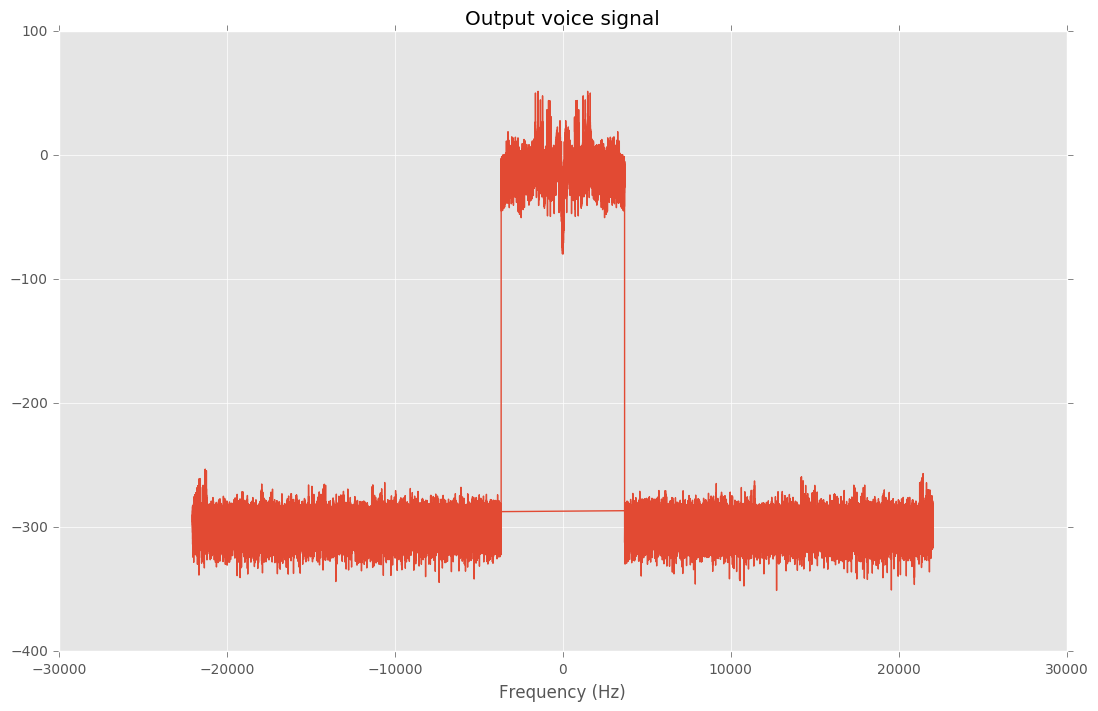

In [15]:
n = g.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

ft_g = fft(g)/len(g)

plt.plot(freq, 20*log10(abs(ft_g)))
plt.xlabel('Frequency (Hz)')
plt.title('Output voice signal')
plt.show()

## Ouvir sinal de saída (re)amostrado a 44,1 kHz

In [16]:
# makes array c_contiguous in memory
g = np.ascontiguousarray(g, dtype=np.int16)

play_obj = sa.play_buffer(g, num_channels, bytes_per_sample, sample_rate)
play_obj.wait_done()